# How does daily PM10 air pollution level differs between Kraków and Warsaw?

The first question I want to answer is close to my heart: air polution in places we live. 

Recently I was wondering how does it differ between Polish two biggest cities: Warsaw and Kraków. Kraków for sure has the opinion of the most polluted Polish city (most likely for a reason - but let's wait for the data). However recently also Warsaw entered this "high pollution" state. 

Let's see how do they compare for the past year. First let's get the data.

## Data wrangling

### Kraków
Kraków is rather easy. We can get official air pollution measurements for the past year on Wojewódzki Inspektorat Środowiska w Krakowie [website](http://monitoring.krakow.pios.gov.pl/). There are several measurement stations in Kraków. This is simple (but not simplistic!) analysis so I decided to choose the one the most in the city center instead of for example averaging all of them. So we choose measurement station located in Aleja Krasińskiego ([here](http://monitoring.krakow.pios.gov.pl/stacje/stacja/6)). We will use data from October 2016 to September 2017 (12 full months). 

We need to manually download the csv file for each month from the website. Now our task is to wrangle a little with it and join all 12 csv files into one data set and check if it was correctly loaded. 

We start with loading needed modules and setting the plots to appear inline (in Jupyter notebook itself insetad of opening separate window).

In [224]:
import pandas as pd
import matplotlib.pyplot as plt

%matplotlib inline

Let's now see how the raw csv file structure looks like.

In [225]:
!cat "datasets/krakow-dane-pomiarowe_2017-10-08_23-44-16.csv"

"CZAS";"NO2 Dwutlenek azotu  [µg/m3]";"NOx Tlenki azotu  [µg/m3]";"NO Tlenek azotu  [µg/m3]";"CO Tlenek węgla  [µg/m3]";"CO Tlenek węgla 8h poz. dop.: 10000 [µg/m3]";"C6H6 Benzen  [µg/m3]";"PM10 Pył zawieszony PM10 poz. dop.: 50 [µg/m3]";"PM2.5 Pył zawieszony PM2.5  [µg/m3]"
"01.12";"41";"132";"59";"648";"764";"1,4";"28";"21"
"02.12";"42";"130";"58";"606";"804";"1,1";"26";"17"
"03.12";"42";"123";"53";"641";"856";"1,4";"41";"27"
"04.12";"54";"208";"100";"1246";"2230";"3,7";"93";"67"
"05.12";"75";"368";"192";"2145";"2727";"8,6";"181";"129"
"06.12";"55";"210";"101";"1003";"1677";"2,7";"74";"55"
"07.12";"72";"313";"158";"1278";"1768";"3,5";"99";"66"
"08.12";"60";"196";"89";"957";"1683";"2,4";"69";"46"
"09.12";"51";"161";"72";"813";"957";"1,6";"54";"30"
"10.12";"39";"115";"50";"753";"811";"1,4";"38";"24"
"11.12";"33";"92";"39";"670";"779";"1,0";"28";"19"
"12.12";"50";"157";"70";"713";"866";"0,9";"29";"16"
"13.12";"71";"310";"157";"1273";"1717";"3,1";"103";"63"
"14.12";"57";"230";"113";"1199

So we see that we will need to use ";" as a delimeter when loading the data. 

Also columns names are not to nicely formatted so it would be better if we will name them more concisely when loading the csv files. 

Another problem is that the last three rows contain agregated information (mean, min, max) and we want to keep only raw measurements. That is why we will drop last three rows from each data set.

We can also see that the data set uses ',' as a decimal separator. Missing measurements in the data are marked with `-` which should be converted to NaN format.

The last problem is the fact that source site generates record with strange date format without a year! For data series like this one it is crucial information and not having it makes it error prone. YYYY-mm-dd date format (e.g. 2016-10-01) is the most popular one and it would be useful to format it the same way Warsaw data set dates are formatted and add year information. It will be useful later in creating both cities data visualisations.

Let's now iterate through all 12 csv files, read them, merge into one DataFrame and solve mentioned problems. Then we'll check data integrity.

We start with creating merged data DataFrame.

In [226]:
import numpy as np
import os
DATA_PATH = "datasets/"

krakow_csv_list = os.listdir(DATA_PATH)
columns = ["date", "no2 [µg/m3]", "nox [µg/m3]", "no [µg/m3]", "co [µg/m3]", "co8h [µg/m3]", "c6h6 [µg/m3]", "pm10 [µg/m3]", "pm2.5 [µg/m3]"]
krakow_df_list = [pd.read_csv(DATA_PATH+krakow_csv, delimiter=";", names=columns, skiprows=1, decimal=",", na_values=["-", "-1)"]).iloc[:-3] for krakow_csv in krakow_csv_list[::-1] if "krakow" in krakow_csv]

krakow_df = pd.concat(krakow_df_list, axis=0)
krakow_df = krakow_df.reset_index(drop=True)

Then we check infered data types. 

In [227]:
krakow_df.dtypes

date              object
no2 [µg/m3]      float64
nox [µg/m3]      float64
no [µg/m3]       float64
co [µg/m3]         int64
co8h [µg/m3]     float64
c6h6 [µg/m3]     float64
pm10 [µg/m3]       int64
pm2.5 [µg/m3]    float64
dtype: object

The date column should be in datetime type with format we described above. 

In [228]:
from datetime import datetime

def convert_dates_and_add_year(date):
    reversed_split_date = date.split(".")[::-1]
    if int(reversed_split_date[0]) > 9:
        date_str = "2016-"+"-".join(reversed_split_date)
    else:
        date_str = "2017-"+"-".join(reversed_split_date)
    return datetime.strptime(date_str, "%Y-%m-%d")

krakow_df["date"] = krakow_df["date"].apply(convert_dates_and_add_year)
krakow_df.index = krakow_df['date']
krakow_df = krakow_df.sort_values(by='date')

In [229]:
krakow_df.dtypes

date             datetime64[ns]
no2 [µg/m3]             float64
nox [µg/m3]             float64
no [µg/m3]              float64
co [µg/m3]                int64
co8h [µg/m3]            float64
c6h6 [µg/m3]            float64
pm10 [µg/m3]              int64
pm2.5 [µg/m3]           float64
dtype: object

In [230]:
krakow_df.head()

,date,no2 [µg/m3],nox [µg/m3],no [µg/m3],co [µg/m3],co8h [µg/m3],c6h6 [µg/m3],pm10 [µg/m3],pm2.5 [µg/m3]
date,,,,,,,,,
2016-10-01,2016-10-01,74.0,235.0,105.0,963,1409.0,2.1,60,36.0
2016-10-02,2016-10-02,63.0,174.0,73.0,841,1281.0,2.1,53,34.0
2016-10-03,2016-10-03,53.0,158.0,69.0,579,781.0,1.3,25,17.0
2016-10-04,2016-10-04,47.0,158.0,73.0,504,620.0,1.3,19,11.0
2016-10-05,2016-10-05,34.0,117.0,54.0,394,562.0,1.3,13,9.0


In [231]:
krakow_df.tail(10)

,date,no2 [µg/m3],nox [µg/m3],no [µg/m3],co [µg/m3],co8h [µg/m3],c6h6 [µg/m3],pm10 [µg/m3],pm2.5 [µg/m3]
date,,,,,,,,,
2017-09-21,2017-09-21,60.0,177.0,76.0,753,1058.0,1.4,21,19.0
2017-09-22,2017-09-22,56.0,185.0,84.0,759,897.0,1.4,30,25.0
2017-09-23,2017-09-23,39.0,132.0,61.0,789,949.0,1.8,27,25.0
2017-09-24,2017-09-24,42.0,164.0,80.0,867,976.0,1.8,26,22.0
2017-09-25,2017-09-25,50.0,204.0,101.0,860,1014.0,1.6,33,25.0
2017-09-26,2017-09-26,47.0,249.0,132.0,1032,1407.0,2.6,53,39.0
2017-09-27,2017-09-27,52.0,161.0,71.0,763,1294.0,1.7,45,28.0
2017-09-28,2017-09-28,59.0,201.0,92.0,839,1030.0,1.8,46,29.0
2017-09-29,2017-09-29,69.0,317.0,161.0,1194,NaN,NaN,73,51.0


In [232]:
krakow_df.count()

date             365
no2 [µg/m3]      363
nox [µg/m3]      363
no [µg/m3]       363
co [µg/m3]       365
co8h [µg/m3]     364
c6h6 [µg/m3]     342
pm10 [µg/m3]     365
pm2.5 [µg/m3]    305
dtype: int64

The data looks corrects with records starting 2016-10-01 and ending 2017-09-30. This means that we should have 365 records which is proved for our DataFrame records number.

### Warsaw

Getting Warsaw data is even easier! We get the official air pollution measurements for the past year on Główny  Inspektorat Środowiska [website](http://powietrze.gios.gov.pl/). There are also several measurement stations in Warsaw. Again we decided to choose the one the most in the city center - we choose measurement station located in ul. Marszałkowska 68. In this case we can generate manually data set for given range of dates, measured pollutant and selected measurement station ([here](http://powietrze.gios.gov.pl/pjp/current/station_details/archive/544)).

Let's see how downloaded data set looks like.

In [233]:
!cat datasets/warszawa-gios-pjp-data.csv

Zanieczyszczenie;Warszawa-Marszałkowska - pył zawieszony PM10
Jednostka;ug/m3
2016-10-01;36.0
2016-10-02;34.7
2016-10-03;32.1
2016-10-04;25.6
2016-10-05;10.6
2016-10-06;23.2
2016-10-07;28.1
2016-10-08;20.0
2016-10-09;23.9
2016-10-10;22.7
2016-10-11;14.2
2016-10-12;17.1
2016-10-13;27.5
2016-10-14;36.0
2016-10-15;32.4
2016-10-16;28.2
2016-10-17;30.9
2016-10-18;30.5
2016-10-19;
2016-10-20;
2016-10-21;32.4
2016-10-22;29.1
2016-10-23;39.2
2016-10-24;38.7
2016-10-25;35.5
2016-10-26;28.7
2016-10-27;39.4
2016-10-28;39.9
2016-10-29;14.2
2016-10-30;12.8
2016-10-31;14.5
2016-11-01;19.5
2016-11-02;15.6
2016-11-03;15.0
2016-11-04;30.2
2016-11-05;51.2
2016-11-06;34.5
2016-11-07;34.5
2016-11-08;46.8
2016-11-09;42.2
2016-11-10;48.3
2016-11-11;39.7
2016-11-12;51.5
2016-11-13;42.0
2016-11-14;38.2
2016-11-15;49.9
2016-11-16;31.9
2016-11-17;31.9
2016-11-18;42.3
2016-11-19;45.4
2016-11-20;26.9
2016-11-21;37.9
2016-11-22;37.6
2016-11-23;54.8
2016-11-24;71.6
2016-11-25;57.2
2016-11-26;49.1
2016-11-27;27.1
20

We see here that ";" is the delimeter and that data set has more robust timestamp format conaining a year. 

And among all that data contains only information contains only PM10 measurements so no data wrangling is needed besides naming the columns.

In [234]:
warszawa_df = pd.read_csv(DATA_PATH+"warszawa-gios-pjp-data.csv", delimiter=";", names=["date", "pm10 [µg/m3]"], skiprows=2)
warszawa_df.index = warszawa_df['date']

In [235]:
warszawa_df.head(10)

,date,pm10 [µg/m3]
date,,
2016-10-01,2016-10-01,36.0
2016-10-02,2016-10-02,34.7
2016-10-03,2016-10-03,32.1
2016-10-04,2016-10-04,25.6
2016-10-05,2016-10-05,10.6
2016-10-06,2016-10-06,23.2
2016-10-07,2016-10-07,28.1
2016-10-08,2016-10-08,20.0
2016-10-09,2016-10-09,23.9


In [236]:
warszawa_df.tail(10)

,date,pm10 [µg/m3]
date,,
2017-09-21,2017-09-21,23.3
2017-09-22,2017-09-22,20.2
2017-09-23,2017-09-23,35.0
2017-09-24,2017-09-24,35.3
2017-09-25,2017-09-25,29.7
2017-09-26,2017-09-26,45.8
2017-09-27,2017-09-27,36.0
2017-09-28,2017-09-28,27.2
2017-09-29,2017-09-29,43.6


In [237]:
warszawa_df.count()

date            365
pm10 [µg/m3]    363
dtype: int64

Again data looks complete in our specified dates range. Looks like we miss two measurements, but we will see it later during exploration.

## Exploration

First let's see some PM10 data plots for both cities.

In [238]:
import matplotlib.pyplot as plt
from matplotlib.dates import MonthLocator, DateFormatter
%matplotlib inline

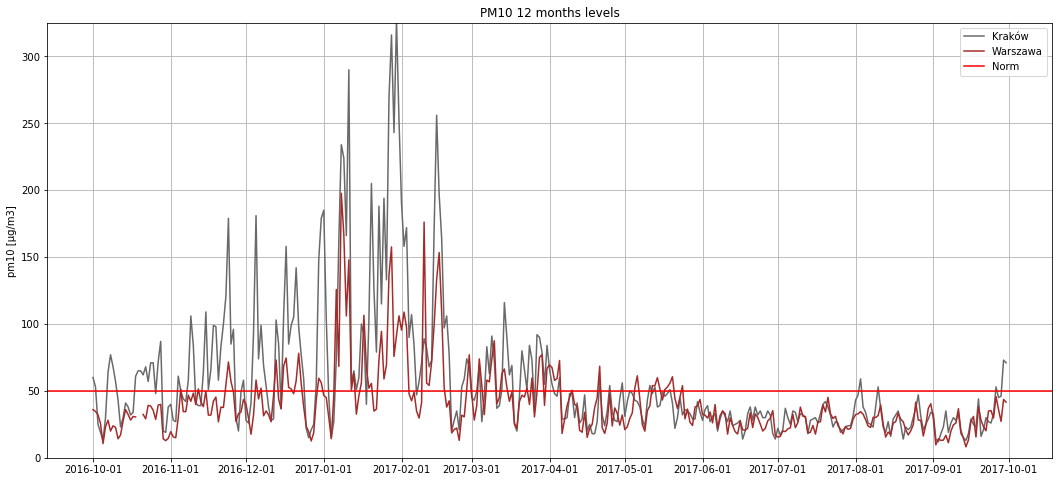

In [239]:
def plot_pm10_comparison_data(axes, data1, data2, label1, label2, title):
    months = MonthLocator(range(1, 13), bymonthday=1, interval=1)
    monthsFmt = DateFormatter("%Y-%m-%d")
    axes.plot_date(data1['date'], data1["pm10 [µg/m3]"], fmt='m', color="dimgrey", label=label1)
    axes.plot_date(data2['date'], data2["pm10 [µg/m3]"], fmt='m', color="brown", label=label2)
    axes.axhline(y=50, color='red', label="Norm")
    axes.set_ylim([0,325])
    axes.xaxis.set_major_locator(months)
    axes.xaxis.set_major_formatter(monthsFmt)
    axes.set_ylabel("pm10 [µg/m3]")
    axes.set_title(title)
    axes.grid(True)
    axes.legend(loc=0)
    
fig, axes = plt.subplots(figsize=(18, 8))
plot_pm10_comparison_data(axes, krakow_df, warszawa_df, "Kraków", "Warszawa", "PM10 12 months levels")

The plot is not clear enough. We can see some differences but there are several factors that makes it difficult analyse. Let's plot it quarterly for more details!


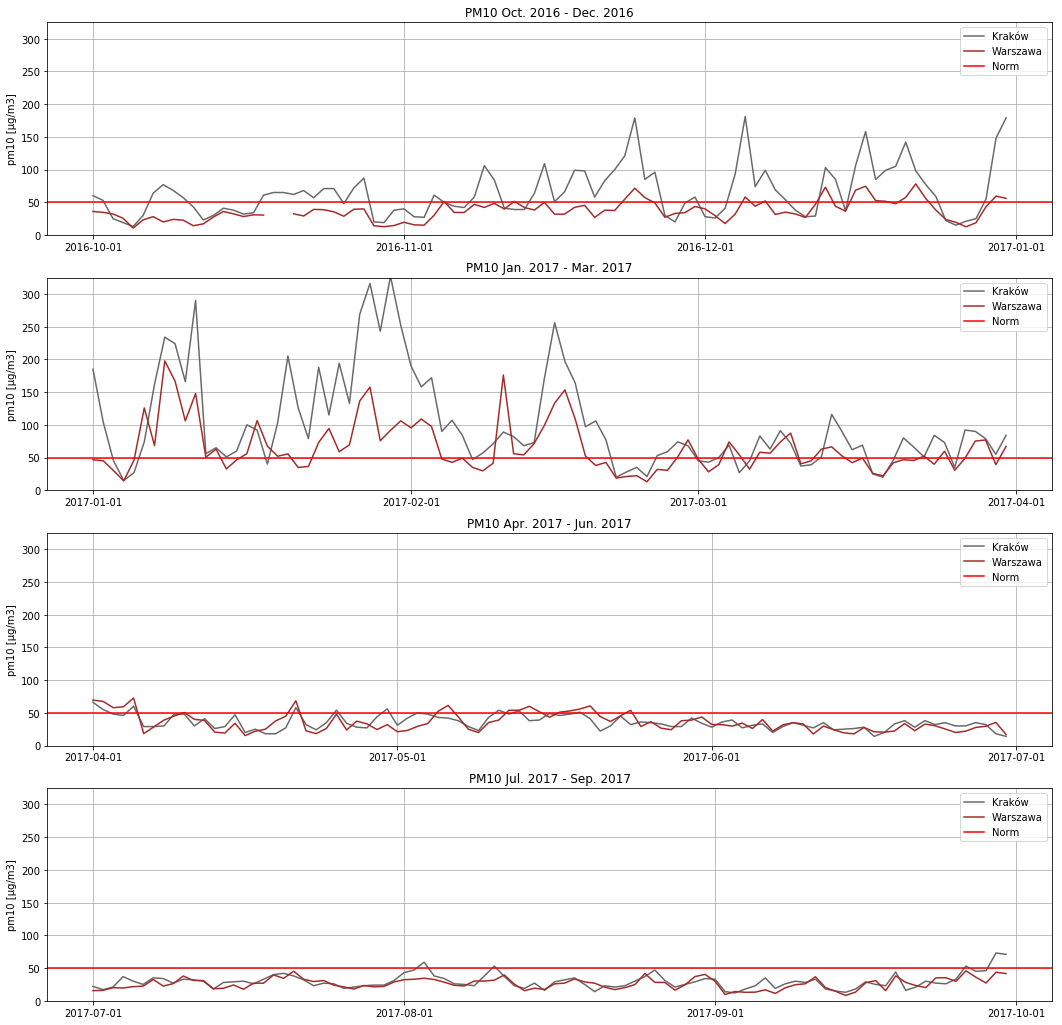

In [240]:
fig, axes = plt.subplots(4, 1, figsize=(18, 18))
plot_pm10_comparison_data(axes[0], krakow_df.loc["2016-10-01":"2016-12-31"], 
                          warszawa_df.loc["2016-10-01":"2016-12-31"], "Kraków", "Warszawa", "PM10 Oct. 2016 - Dec. 2016")
plot_pm10_comparison_data(axes[1], krakow_df.loc["2017-01-01":"2017-03-31"], 
                          warszawa_df.loc["2017-01-01":"2017-03-31"], "Kraków", "Warszawa", "PM10 Jan. 2017 - Mar. 2017")
plot_pm10_comparison_data(axes[2], krakow_df.loc["2017-04-01":"2017-06-30"], 
                          warszawa_df.loc["2017-04-01":"2017-06-30"], "Kraków", "Warszawa", "PM10 Apr. 2017 - Jun. 2017")
plot_pm10_comparison_data(axes[3], krakow_df.loc["2017-07-01":"2017-09-30"], 
                          warszawa_df.loc["2017-07-01":"2017-09-30"], "Kraków", "Warszawa", "PM10 Jul. 2017 - Sep. 2017")

## Conclusions and answer

Now we can try to answer question stated in the begining: How does daily PM10 air pollution level differs between Kraków and Warsaw? 

First how does it look like from plot. We can see that in seven months of the year (March 2017 - September 2017) PM10 levels in Kraków and Warszawa are more or less similar. These two periods are part of the year where polution is in general lower due to warmer weather not using heating systems. So we have part of our answer: in the period from March 2017 to the end of September 2017 PM10 polution levels more or less follow each other.

What about the other 5 months of the year? We mean here period from October 2016 to the end of Ferbruary 2017. We can see that a lots of daily PM10 levels in both cities are much above safe 50 µg/m3 level. We can also see that the level of polution in that period is much bigger in Kraków. And that is the other part of our answer to the question stated in the begining.

But like really - by how is much Kraków PM10 air polution level worse in October 2016 - Ferbruary 2017 period? Let's try to answer this more detailed question by creating a few metrics. First let's see what is the average level PM10 for whole second - colder - period in both cities.

In [241]:
print("Kraków PM10 October 2016 - Ferbruary 2017 mean level: ", \
      krakow_df["pm10 [µg/m3]"].loc["2016-10-01":"2017-02-28"].mean())

Kraków PM10 October 2016 - Ferbruary 2017 mean level:  87.21192052980132


In [242]:
print("Warszawa PM10 October 2016 - Ferbruary 2017 mean level: ", \
      warszawa_df["pm10 [µg/m3]"].loc["2016-10-01":"2017-02-28"].mean())

Warszawa PM10 October 2016 - Ferbruary 2017 mean level:  50.980536912751674


We can clearly see that again Kraków mean is much bigger than Warszawa mean. The problem with the mean is that it does not clearly enough accents the periods with high polution which are flatten in calculation by days with much lower polutions.

Let's try something different - the number of days in which PM10 polution level was above the 50 µg/m3 norm.

In [243]:
print("Kraków PM10 October 2016 - Ferbruary 2017 number of days above the norm: ", sum(krakow_df["pm10 [µg/m3]"]>50))

Kraków PM10 October 2016 - Ferbruary 2017 number of days above the norm:  138


In [244]:
print("Warszawa PM10 October 2016 - Ferbruary 2017 number of days above the norm: ", sum(warszawa_df["pm10 [µg/m3]"]>50))

Warszawa PM10 October 2016 - Ferbruary 2017 number of days above the norm:  85


Again Kraków PM10 levels polution is much worse, but still we do not take into consideration by HOW MUCH was the norm crossed and instead we onluy count days when it occured. So in this metrics we treat the same way the situation when in one city poluttion was about 75 µg/m3 when in the other it hit giant 250 µg/m3 level. 

The last metrics that takes into consideration not only the fact the the norm was crossed but also by how much. In order to do this we will sum the area of the curve (as presented on the above plots) above the norm for each days in both in Kraków and Warszawa and compare. This way we will measure by how much in the whole period the norm was crossed in total in both cities and be able to compare it.

In [245]:
shifted_krakow_df = krakow_df["pm10 [µg/m3]"] - 50 # first we shift all the value to leave just the values above the norm
shifted_krakow_df[shifted_krakow_df < 0] = 0 # then we neglect the negative values
print("Kraków PM10 October 2016 - Ferbruary 2017 value of how much the norm was crossed in total: ", shifted_krakow_df.sum()) # then we sum by how much each measurement was above the norm (0 if was below or equal to norm)

Kraków PM10 October 2016 - Ferbruary 2017 value of how much the norm was crossed in total:  7115


In [246]:
shifted_warszawa_df = warszawa_df["pm10 [µg/m3]"] - 50
shifted_warszawa_df[shifted_warszawa_df<0] = 0
print("Warszawa PM10 October 2016 - Ferbruary 2017 value of how much the norm was crossed in total: ", shifted_warszawa_df.sum())

Warszawa PM10 October 2016 - Ferbruary 2017 value of how much the norm was crossed in total:  2204.500000000001


And here we can see that finally we quantified the giant air quality difference beteen Kraków and Warszawa which we could see in the plots. Overal norm crossing values sum in the period from October 2016 to the end of Ferbruary 2017 was over three times bigger in Kraków then in Warszawa.

To sum up, the answer to the question "How does daily PM10 air pollution level differs between Kraków and Warsaw?"
is that Kraków air polution (measured in PM10 levels) is much worse in Kraków. As we saw it clearly in the plots, but also showed in created metrics. Whereas in March 2017 - September 2017 period the PM10 polution levels are similar in both cities, October 2016 to the end of Ferbruary 2017 period polution levels are much worse in Kraków. Considering our last metrics, showing overal sum of how much the norm was crossed in the whole period, the polution norm crossing is over three times higher in Kraków then in Warsaw.

The last interesting thing is the clearly visible relation between both cities' polution levels. It is clearly visible in the last two quarters, but also in the first two. And this looks like area that could be interesting for future analysis: what are the common factors that cause the similar polution behaviours? Identifying those would help in creating a predictive model of PM10 - and other pollutants - and possibly predict their behaviours in the future. Also this relation would not be visible if we analysed just single city polution levels data series. And deepening this type of comparative analysis in the future looks really interesting!